# Adiabatic Flame Temperature for Rocket Propulsion Applications
*Daniel I Pineda, James L. Urban, and Carlos Fernandez-Pello*, 2017

### Exotic fuel/oxidizer mixtures for rocket propulsion
In this example, we go over the concept of adiabatic flame temperature as in the other example, but we expand the fuel/air mixtures to encompass more exotic substances, such as rocket propellants. As in the last example, the adiabtic flame temperature is the temperature of a system at chemical and thermodynamic equilibrium. Additionally, we also determine the mean molecular weight of the product gases and the ratio of specific heats of the product gases. These properties are needed to perform rocket engine thrust calculations. 

The initial state in our case is a collection of reactants (fuel and oxidizer) at a specified temperature and pressure. The Cantera functions used in this example act to minimize the Gibbs free energy of the system. 

This example is separate from the other example because we use a different thermodynamic data file, modified from the [NASA thermodynamic database](http://www.galcit.caltech.edu/EDL/public/thermo.html). This file contains many more substances than the thermodynamic file included with the [GRI-MECH 3.0 mechanism](http://combustion.berkeley.edu/gri-mech/version30/text30.html). 

### Import Packages
- [cantera](http://www.cantera.org/docs/sphinx/html/index.html): A Combustion Chemistry Python Module 
    - Chemical Equilibrium
    - 1-D Flame Speed
    - Surface Chemistry
- [numpy](http://www.numpy.org/): A Mathematical Function Libary (similiar functions to MATLAB) 
    - Linear Algegra
    - Root Finding
    - Simple Data Analysis
- [matplotlib](http://matplotlib.org/): A Python Figure making and Plotting Software 

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Intitialize Gas Object
For this example we will initialize a gas object ("`gas1`") using a modified version of the [NASA thermodynamic database](http://www.galcit.caltech.edu/EDL/public/thermo.html), which does not contain chemical reactions, but contains more exotic substances often used as rocket propellants. 

In [2]:
gas1 = ct.Solution('./nasa_gas.cti')

### Set Initial Gas Mixture and Conditions
The gas mixture we will first examine will be a mixture with the following conditions:
- Composition: Stoichiometric ethanol (C$_2$H$_5$OH) and oxygen (O$_2$). The ethanol is diluted with 75% water. 
- $T = 300~K$
- $P = 1724~kPa$

These conditions represent the entrance of a rocket engine combustion chamber operating at steady state. 

Additionally, we introduce the Oxidizer / Fuel mass ratio (O/F ratio) which is often used in propulsion applications because propulsion engineers typically measure mass flow rates rather than molar flow rates:

$O/F = \frac{m_{oxidizer}}{m_{fuel}}$ 

We can relate this to equivalence ratio $\phi$ by:

$\phi = \frac{(O/F)_{stoich}}{(O/F)_{actual}}$

where, for a fuel with the formula C$_{\alpha}$H$_{\beta}$O$_{\gamma}$: 

$(O/F)_{stoich} = \frac{(\alpha + \beta/4 + \gamma/2) \times M_{O2}}{M_{fuel}}$

The "`gas1()`" command prints out information about the initial state of the fuel/air mixture, include the internal energy, enthalpy, density, and other properties which you can see in the output below. 

In [3]:
gas1.TP = 300, 1.724e+6   # [K], [Pa]
phi = 1
gas1.set_equivalence_ratio(phi,'C2H5OH:0.75, H2O:0.25','O2:1')
gas1()


  nasa_gas:

       temperature             300  K
          pressure       1.724e+06  Pa
           density         23.6172  kg/m^3
  mean mol. weight         34.1701  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -2.1291e+06       -7.275e+07     J
   internal energy     -2.2021e+06       -7.524e+07     J
           entropy          5986.1        2.045e+05     J/K
    Gibbs function     -3.9249e+06       -1.341e+08     J
 heat capacity c_p            1114        3.806e+04     J/K
 heat capacity c_v          870.64        2.975e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.692308         0.648315         -22.2074
               H2O      0.0769231        0.0405556         -119.391
            C2H5OH       0.230769         0.311129         -126.573
     [  +26 minor]     

### Allow Gas Mixture to Equilibrate
In order to get the adiabatic flame temperature we need to react the fuel/air mixture, we can do that with the "`gas1.equilibrate('HP')`" command which will react the mixture to equilibrium while holding enthalpy and pressure constant.

Then we can print the temperature of the mixture which we can call using the command "`gas1.T`"
Additionally, we can calculate the ratio of specific heats, $\gamma$, of the product gases by calling "`gas1.cp`" and "`gas1.cv`". 
The mean molecular weight of the product gases can be called with "`gas1.mean_molecular_weight`".

In [4]:
gas1.equilibrate('HP')
print "The adiabatic Flame Temperature is {0:.2f} K".format(gas1.T)
ratio = gas1.cp/gas1.cv
print "The ratio of specific heats of the products is {0:.2f}".format(ratio)
print "The molecular weight of the products is {0:.2f} kg/kmol".format(gas1.mean_molecular_weight)

The adiabatic Flame Temperature is 3292.38 K
The ratio of specific heats of the products is 1.20
The molecular weight of the products is 23.99 kg/kmol


### Calculate $T_{adiabatic}$, $MW_{products}$, and $\gamma_{products}$ for various oxidizer/fuel ratios , $O/F$
The previous calculation of the adiabatic flame temperature was relatively simple. With some more effort we can calculate the adiabatic flame temperature for different oxidizer/fuel ratios, ($O/F$) which we can store in the vector "`OFs`" by looping over the equivalence values and recording the temperature

In [5]:
# calculate matrix of mixture ratios vs dilution 

# initialize arrays to hold ethanol dilution values, O/F ratios
dilutions = np.linspace(0.50, 1.00, 11)
OFs = np.linspace(0.25,7.25,71)
# initialize array to hold stoichiometric fuel / air ratios that change depending on fuel water dilution 
stoich_fuel_air_ratio = np.zeros_like(dilutions)

# initialize output arrays for adiabatic flame temperature, specific heat ratios, and molecular weights
T_adiabatic = np.zeros((len(OFs), len(dilutions)))
gammas = np.zeros_like(T_adiabatic)
molecular_weights = np.zeros_like(T_adiabatic)

# initialize Cantera solution object with nasa_gas.cti to get properties of oxygen
ox = ct.Solution('./nasa_gas.cti')
ox.X = "O2:1"
ox_MW = ox.mean_molecular_weight

# main program loop: loop through the different fuel/water dilution levels
for dd, dilution in enumerate(dilutions):
    # initialize Cantera solution object to get properties of fuel
    fuel = ct.Solution('./nasa_gas.cti')
    fuel_dilution = dilutions[dd]
    fuel.X = "C2H5OH:"+ str(fuel_dilution) + ", H2O:" + str(1.0-fuel_dilution)
    fuel_MW = fuel.mean_molecular_weight
    
    # there are three oxygen molecules for every ethanol molecule
    stoich_fuel_air_ratio[dd] = fuel_MW/(fuel_dilution*3*ox_MW) 
    
    # initialize Cantera solution object for the main gas calculation
    gas1 = ct.Solution('./nasa_gas.cti')
    
    # loop through the different O/F ratios 
    for l, OF in enumerate(OFs):
        gas1.TP = 300, 1.724e+6
        phi = 1.0/(OF*stoich_fuel_air_ratio[dd])
        # print things for diagnostic purposes
        #print "dilution:" + str(fuel_dilution)
        #print "OF:" + str(OF)
        #print "Equivalence ratio:" + str(phi)
        gas1.set_equivalence_ratio(phi,"C2H5OH:"+ str(fuel_dilution) + ", H2O:" + str(1.0-fuel_dilution),'O2:1')
        gas1.equilibrate('HP')
        T_adiabatic[l, dd] = gas1.T
        gammas[l,dd] = gas1.cp/gas1.cv
        molecular_weights[l,dd] = gas1.mean_molecular_weight

### Plot $T_{adiabatic}$ vs $\phi$

<IPython.core.display.Javascript object>


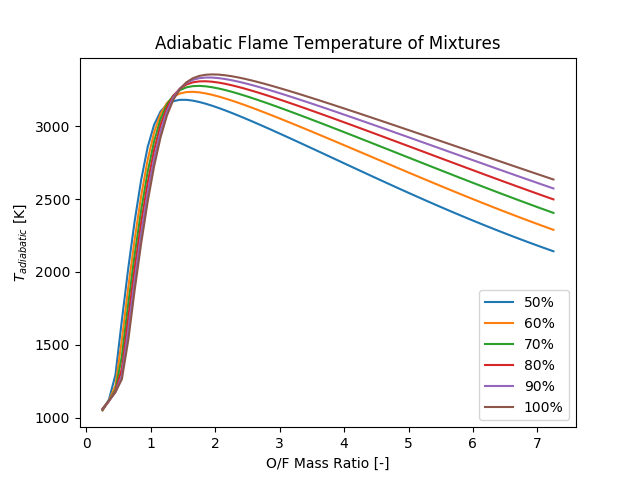

In [6]:
fig, ax = plt.subplots()
ax.set_title("Adiabatic Flame Temperature of Mixtures")
ax.plot(OFs,T_adiabatic[:,0], label='50%')
ax.plot(OFs,T_adiabatic[:,2], label='60%')
ax.plot(OFs,T_adiabatic[:,4], label='70%')
ax.plot(OFs,T_adiabatic[:,6], label='80%')
ax.plot(OFs,T_adiabatic[:,8], label='90%')
ax.plot(OFs,T_adiabatic[:,10], label='100%')
ax.set_xlabel('O/F Mass Ratio [-]')
ax.set_ylabel('$T_{adiabatic}$ [K]')
plt.legend()
plt.show()

### Comments on the Plot of $T_{adiabatic}$ vs O/F ratio

We can see that the highest flame temperature occurs near stoichiometric ($\phi =1$, O/F = ~$2$) and then gets lower as the equivalence ratio gets higher or lower 

<IPython.core.display.Javascript object>


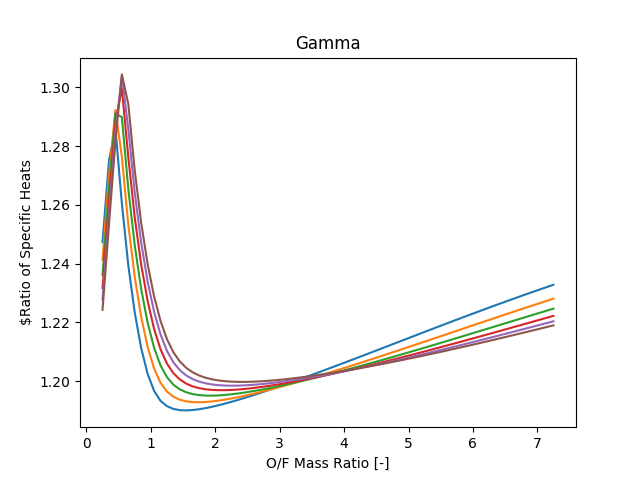

In [7]:
fig, ax = plt.subplots()
ax.set_title("Gamma")
ax.plot(OFs,gammas[:,0])
ax.plot(OFs,gammas[:,2])
ax.plot(OFs,gammas[:,4])
ax.plot(OFs,gammas[:,6])
ax.plot(OFs,gammas[:,8])
ax.plot(OFs,gammas[:,10])
ax.set_xlabel('O/F Mass Ratio [-]')
ax.set_ylabel('$Ratio of Specific Heats')
plt.show()

<IPython.core.display.Javascript object>


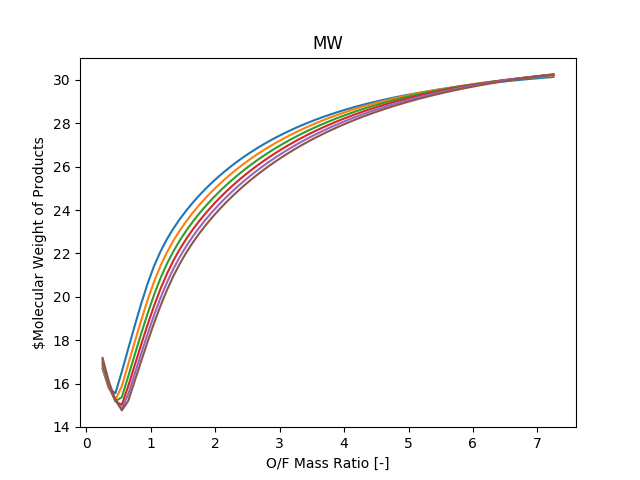

In [8]:
fig, ax = plt.subplots()
ax.set_title("MW")
ax.plot(OFs,molecular_weights[:,0])
ax.plot(OFs,molecular_weights[:,2])
ax.plot(OFs,molecular_weights[:,4])
ax.plot(OFs,molecular_weights[:,6])
ax.plot(OFs,molecular_weights[:,8])
ax.plot(OFs,molecular_weights[:,10])
ax.set_xlabel('O/F Mass Ratio [-]')
ax.set_ylabel('$Molecular Weight of Products')
plt.show()

In [9]:
# save files 
np.savetxt("temp.csv", T_adiabatic, delimiter=",")
np.savetxt("gamma.csv", gammas, delimiter=",")
np.savetxt("MW.csv", molecular_weights, delimiter=",")
np.savetxt("OF.csv", OFs, delimiter=",")
np.savetxt("dilution.csv", dilutions, delimiter=",")
np.savetxt("stoichOF.csv", 1.0/stoich_fuel_air_ratio, delimiter=",")